# Withdraw Prediction

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split # to split the data into two parts
# from sklearn.cross_validation import KFold # use for cross validation
from sklearn.preprocessing import StandardScaler # for normalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline # pipeline making
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics # for the check the error and accuracy of the model
from sklearn.metrics import mean_squared_error,r2_score

import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from xgboost import plot_importance, plot_tree

import tensorflow as tf
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError
from tensorflow.keras.models import Sequential

from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima.arima import auto_arima

In [2]:
# Load data
data_df = pd.read_csv('data.csv')
data_df.head(5)

,month,createdDate,date,userid,withdraw,bonus,balance
0,2021-01,2021-01-01,1,1240477354,0,69000,5412430
1,2021-01,2021-01-01,1,1240478472,0,300000,6106732
2,2021-01,2021-01-01,1,1240486783,0,9000,720980
3,2021-01,2021-01-01,1,1240486932,475000,0,0
4,2021-01,2021-01-01,1,1240488466,300000,300000,0


In [3]:
# data show amount of money that users withdraw everyday
date_df = data_df.groupby(by=['createdDate']).aggregate({
    'month': 'first',
    'date': 'first',
    'userid': 'count',
    'withdraw': sum,
    'bonus': sum,
    'balance': sum
}).reset_index()
date_df.head()

,createdDate,month,date,userid,withdraw,bonus,balance
0,2021-01-01,2021-01,1,29,23378685,2307427,16333438
1,2021-01-02,2021-01,2,65,20308268,17080444,70557517
2,2021-01-03,2021-01,3,55,11501436,8859088,69275021
3,2021-01-04,2021-01,4,241,96487909,75036581,151610350
4,2021-01-05,2021-01,5,226,82418083,74384979,165554053


In [4]:
date_df['year'] = date_df.month.apply(lambda x: x.split('-')[0]).astype(int)
date_df.month = date_df.month.apply(lambda x: x.split('-')[1]).astype(int)

In [5]:
# Statistical describe
date_df[['withdraw', 'userid', 'bonus', 'balance']].describe()

,withdraw,userid,bonus,balance
count,4.770000e+02,477.000000,4.770000e+02,4.770000e+02
mean,1.655093e+08,422.209644,1.859176e+08,8.006496e+08
std,1.558111e+08,310.778168,1.445930e+08,5.142655e+08
min,5.000000e+05,4.000000,0.000000e+00,0.000000e+00
25%,6.308960e+07,215.000000,7.113095e+07,3.180221e+08
50%,1.306185e+08,337.000000,1.662539e+08,7.878949e+08
75%,2.187791e+08,550.000000,2.681024e+08,1.184003e+09
max,1.054243e+09,1889.000000,8.070973e+08,2.127543e+09


<AxesSubplot:title={'center':'Withdraw'}, xlabel='createdDate'>

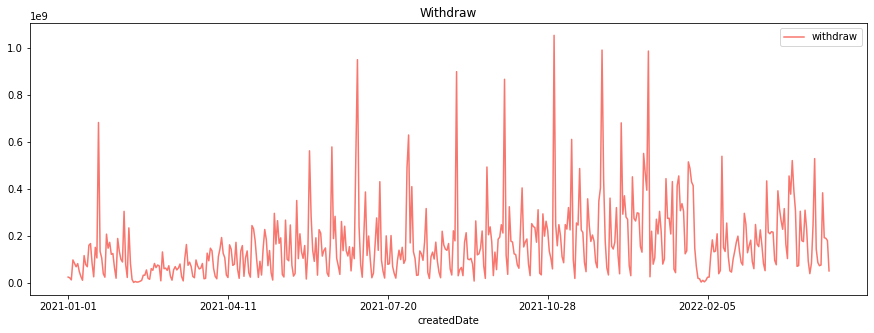

In [6]:
date_df.index = date_df.createdDate
date_df[['withdraw']].plot(figsize=(15,5), color="#F8766D", title='Withdraw')

In [7]:
# Considering correlationship between withdraw feature and other features
corr = date_df[['userid', 'bonus', 'balance']].corrwith(date_df['withdraw'])
corr

userid     0.583863
bonus      0.666872
balance    0.483288
dtype: float64

interactive(children=(Dropdown(description='name', options=('RdBu', 'RdGy', 'PRGn', 'PiYG', 'BrBG', 'RdYlBu', …

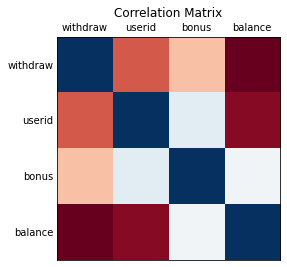

In [8]:
dpal = sns.choose_colorbrewer_palette('diverging', as_cmap=True)
plt.matshow(date_df[['withdraw','userid', 'bonus', 'balance']].corr(), cmap=dpal)
ax = plt.gca()
ax.tick_params(axis='both', which='both',length=0);
plt.title("Correlation Matrix")
plt.xticks(range(4), ['withdraw','userid', 'bonus', 'balance'])
plt.yticks(range(4), ['withdraw','userid', 'bonus', 'balance']);

Text(0, 0.5, 'withdraw (t)')

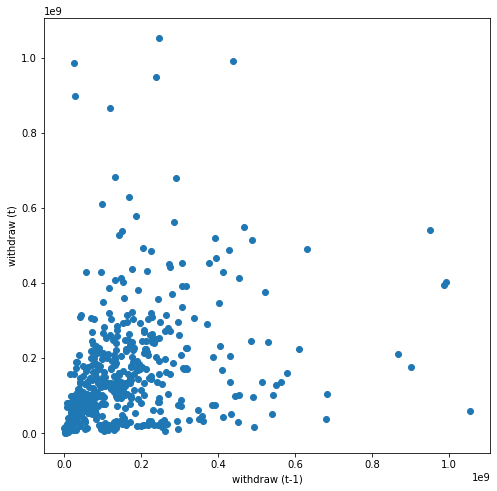

In [9]:
# Considering the problem is a time series prolem
# check the sequence of withdraw order by datetime
plt.figure(figsize=(8,8))
plt.scatter(date_df['withdraw'].values[1:], date_df['withdraw'].values[:-1])
plt.xlabel('withdraw (t-1)')
plt.ylabel('withdraw (t)')

C:\Users\ASUS\Miniconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'frequency')

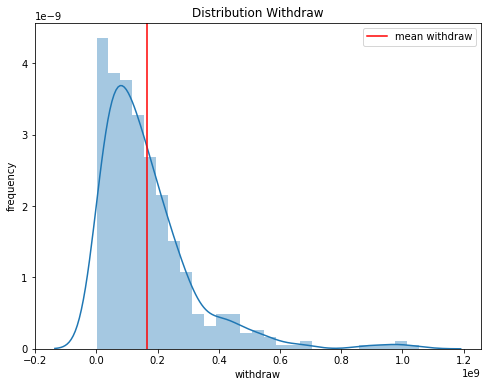

In [10]:
# estimating the distribution of
plt.figure(figsize = (8, 6))
sns.distplot(date_df['withdraw'])
plt.axvline(x=date_df['withdraw'].mean(), label='mean withdraw', c='red')
plt.title('Distribution Withdraw')
plt.legend()
plt.xlabel('withdraw')
plt.ylabel('frequency')

In [11]:
# Firstly, Using the simplest model ARIMA to predict

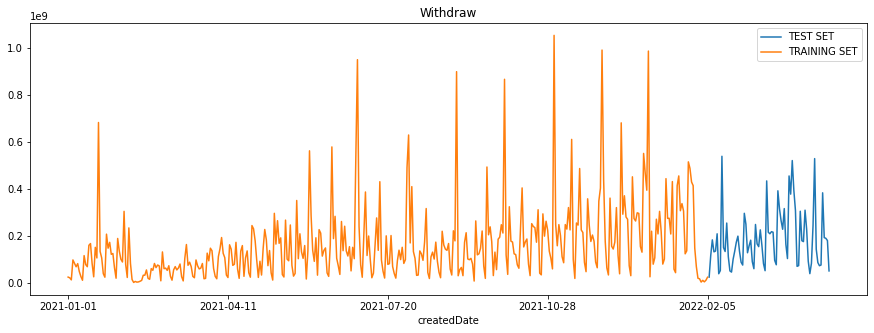

In [12]:
# Secondly, Using XGboost model to predict
train_df = date_df[date_df.index <= '2022-02-05']
test_df = date_df[date_df.index > '2022-02-05']
_ = test_df[['withdraw']] \
    .rename(columns={'withdraw': 'TEST SET'}) \
    .join(train_df[['withdraw']].rename(columns={'withdraw': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='Withdraw')

In [13]:
def create_features(df):
    """
    Creates time series features from datetime index
    """
    X = df[['year', 'month', 'date', 'balance', 'bonus']]
    y = df['withdraw']
    return X, y

In [14]:
X_train, y_train = create_features(train_df)
X_test, y_test = create_features(test_df)

In [15]:
reg = xgb.XGBRegressor(n_estimators=50)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=10,
       verbose=False)

C:\Users\ASUS\Miniconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=50, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

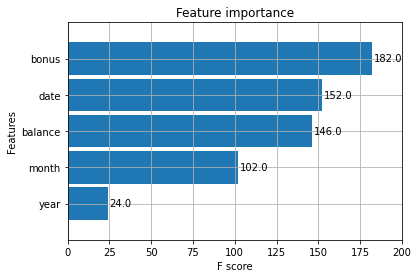

In [16]:
_ = plot_importance(reg, height=0.9)

In [17]:
test_df['Prediction'] = reg.predict(X_test)
date_df = pd.concat([train_df, test_df], sort=False)

<ipython-input-17-ac736f60046b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['Prediction'] = reg.predict(X_test)


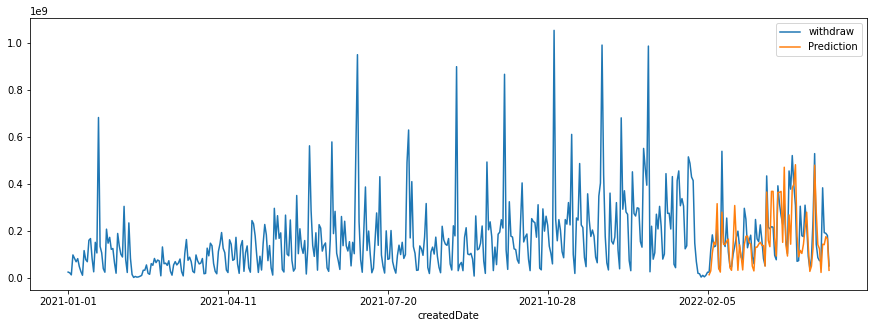

In [18]:
_ = date_df[['withdraw','Prediction']].plot(figsize=(15, 5))

In [45]:
def measure_metric(y, yhat, scale_max=0, scale_min=0):
    e = y-yhat
    if scale_max !=0 or scale_min !=0:
        e = (scale_max - scale_min)*e + scale_min
    mse=np.mean(e**2)
    rmse=np.sqrt(mse)
    mae=np.mean(np.abs(e))
    mape=np.mean(e/y)
    print('Mean Square Error: {}'.format(mse))
    print('Root Mean Square Error: {}'.format(rmse))
    print('Mean Absolute Error: {}'.format(mae))
    print('Mean Absolute Percentage Error: {}'.format(mape))
    return mse, rmse, mae, mape

In [25]:
_, _, _, _ = measure_metric(y_test.values, test_df['Prediction'].values)

Mean Square Error: 8594517494254508.0
Root Mean Square Error: 92706620.55244225
Mean Absolute Error: 68314989.51315789
Mean Absolute Percentage Error: 0.03949572407348791


In [26]:
# Thirdly, Tryong to use LSTM to predict
tf_data = date_df.copy()

In [27]:
train_number = tf_data[tf_data.index <= '2022-02-05'].shape[0]

In [29]:
# min_withdraw, max_withdraw = tf_data['withdraw'].min, tf_data['withdraw'].max
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(tf_data[['month', 'date', 'year', 'userid', 'balance', 'bonus', 'withdraw']].values)

In [30]:
train_ds, test_ds = dataset[: train_number], dataset[train_number:]
train_ds.shape, test_ds.shape

((401, 7), (76, 7))

In [31]:
def create_sequence(arr, sequence_len=7):
    res = []
    n, n_dim = arr.shape
    for i in range(n-sequence_len):
        session = []
        for j in range(sequence_len):
                session = session + list(arr[i + j])
        res += session
    return np.reshape(np.array(res), (n-sequence_len, sequence_len, n_dim))

In [32]:
train_ds = create_sequence(train_ds)
X_train, y_train = train_ds[: -1], train_ds[1:, -1, -1]
X_train.shape, y_train.shape

((393, 7, 7), (393,))

In [33]:
test_ds = create_sequence(test_ds)
X_test, y_test = test_ds[: -1], test_ds[1:, -1, -1]
X_test.shape, y_test.shape

((68, 7, 7), (68,))

In [34]:
def get_model(params, input_shape):
    model = Sequential()
    model.add(LSTM(units=params["lstm_units"], return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(rate=params["dropout"]))

    model.add(LSTM(units=params["lstm_units"], return_sequences=True))
    model.add(Dropout(rate=params["dropout"]))

    model.add(LSTM(units=params["lstm_units"], return_sequences=True))
    model.add(Dropout(rate=params["dropout"]))

#     model.add(LSTM(units=params["lstm_units"], return_sequences=True))
#     model.add(Dropout(rate=params["dropout"]))
    
    model.add(LSTM(units=params["lstm_units"], return_sequences=False))
    model.add(Dropout(rate=params["dropout"]))

    model.add(Dense(1))
    model.compile(loss=params["loss"],
            optimizer=params["optimizer"],
            metrics=[RootMeanSquaredError(), MeanAbsoluteError()])

    return model

In [35]:
params = {
    "loss": "mean_squared_error",
    "optimizer": "adam",
    "dropout": 0.2,
    "lstm_units": 90,
    "epochs": 50,
    "batch_size": 50,
#     "es_patience" : 10
}

In [36]:
model = get_model(params=params, input_shape=X_train.shape[1])

In [37]:
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=params["epochs"],
    batch_size=params["batch_size"],
)

Epoch 1/50
8/8 [==============================] - 8s 273ms/step - loss: 0.0309 - root_mean_squared_error: 0.1756 - mean_absolute_error: 0.1208 - val_loss: 0.0132 - val_root_mean_squared_error: 0.1151 - val_mean_absolute_error: 0.0938
Epoch 2/50
8/8 [==============================] - 0s 26ms/step - loss: 0.0222 - root_mean_squared_error: 0.1489 - mean_absolute_error: 0.0977 - val_loss: 0.0141 - val_root_mean_squared_error: 0.1187 - val_mean_absolute_error: 0.0878
Epoch 3/50
8/8 [==============================] - 0s 26ms/step - loss: 0.0216 - root_mean_squared_error: 0.1471 - mean_absolute_error: 0.1007 - val_loss: 0.0133 - val_root_mean_squared_error: 0.1151 - val_mean_absolute_error: 0.0948
Epoch 4/50
8/8 [==============================] - 0s 27ms/step - loss: 0.0203 - root_mean_squared_error: 0.1425 - mean_absolute_error: 0.0942 - val_loss: 0.0123 - val_root_mean_squared_error: 0.1108 - val_mean_absolute_error: 0.0853
Epoch 5/50
8/8 [==============================] - 0s 25ms/step - lo

8/8 [==============================] - 0s 34ms/step - loss: 0.0168 - root_mean_squared_error: 0.1298 - mean_absolute_error: 0.0824 - val_loss: 0.0108 - val_root_mean_squared_error: 0.1039 - val_mean_absolute_error: 0.0722
Epoch 37/50
8/8 [==============================] - 0s 30ms/step - loss: 0.0168 - root_mean_squared_error: 0.1295 - mean_absolute_error: 0.0892 - val_loss: 0.0242 - val_root_mean_squared_error: 0.1557 - val_mean_absolute_error: 0.1242
Epoch 38/50
8/8 [==============================] - 0s 34ms/step - loss: 0.0168 - root_mean_squared_error: 0.1295 - mean_absolute_error: 0.0816 - val_loss: 0.0110 - val_root_mean_squared_error: 0.1048 - val_mean_absolute_error: 0.0742
Epoch 39/50
8/8 [==============================] - 0s 28ms/step - loss: 0.0168 - root_mean_squared_error: 0.1297 - mean_absolute_error: 0.0820 - val_loss: 0.0113 - val_root_mean_squared_error: 0.1062 - val_mean_absolute_error: 0.0740
Epoch 40/50
8/8 [==============================] - 0s 34ms/step - loss: 0.01

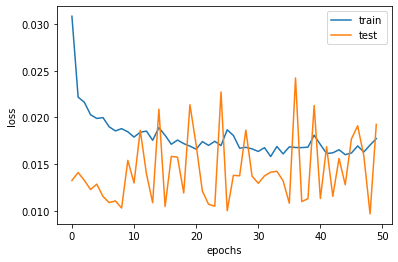

In [58]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

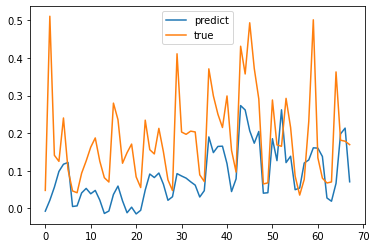

In [39]:
yhat = model.predict(X_test)
plt.plot(yhat, label='predict')
plt.plot(y_test, label='true')
plt.legend()
plt.show()

In [47]:
def measure_metric(y, yhat, scale_max=0, scale_min=0):
    e = y-yhat
    if scale_max !=0 or scale_min !=0:
        e = (scale_max - scale_min)*e
    mse=np.mean(e**2)
    rmse=np.sqrt(mse)
    mae=np.mean(np.abs(e))
    mape=np.mean(e/y)
    print('Mean Square Error: {}'.format(mse))
    print('Root Mean Square Error: {}'.format(rmse))
    print('Mean Absolute Error: {}'.format(mae))
    print('Mean Absolute Percentage Error: {}'.format(mape))
    return mse, rmse, mae, mape

In [56]:
min_withdraw, max_withdraw = tf_data['withdraw'].min(), tf_data['withdraw'].max()
measure_metric(y_test, yhat, scale_max=max_withdraw, scale_min=min_withdraw)

Mean Square Error: 3.2136236300399896e+16
Root Mean Square Error: 179265825.80179608
Mean Absolute Error: 137069262.30521032
Mean Absolute Percentage Error: 293562650.1417365


(3.2136236300399896e+16,
 179265825.80179608,
 137069262.30521032,
 293562650.1417365)

### Conclusion

When using and testing with several model for trial. We can see XGboost is more effective for this particular data. 